# Checking your fitting results

In this notebook, we discuss ways to test the quality of your fitting results.

The key points are:

- Use synthetic data to test your set-up before trying with real data
- Use repeated fits to check the performance of your method on the real problem
- Validate the usefulness of your results by making new predictions

## Checking your optimisation set-up with synthetic data studies

When attempting to fit new experimental data, a pre-study with synthetic data can be extremly helpful:

- It can help spot issues your chosen model, simulator, and optimiser: if the synthetic problem is already difficult, chances of success on the real data set are low!
- Conversely, good performance on a synthetic problem can give you (and others!) confidence that your methodology is sound. This is particularly relevant when the real data results are not as good as hoped, or are hard to interpret.
- Because the "true" parameters are known and because you have control over e.g. the noisiness of the data, synthetic studies can be a great tool to configure or tweak your set-up. For example, we saw in earlier notebooks how they can be used to work out appropriate ODE solver tolerances.
- Experimenting with e.g. different noise levels will help you set expectations for how well the method will perform on real data.

Of course, many new problems can arise when switching from synthetic to real data.
Two common ones are:

1. **The data contains some form of contamination**. For example, in voltage clamp experiments there are often "_voltage-clamp artefacts_" visible in the recorded output which are not part of the ionic current of interest. 
   Similarly, there is usually some amount of _leak_ current and even "_endogeneous currents_": other transmembrane currents that are active during the experiments, and which are native to the cell.
   It is important to realise that _inputs_ can be contaminated as well: even with the very best voltage-clamping the membrane potential will differ in subtle ways from the intended voltage protocol.
2. The model may be (slightly?) wrong, so that you are unable to fit the data well with _any_ set of parameters.
   In statistics, this is sometimes called "**model misspecification**".

These two problems are hard to tell apart, and dealing with them is an active area of research.
However, unless you have strong results on a synthetic data study before starting, it is impossible to say whether these issues are at play or if the methodology is at fault.

The first problem may be partially addressed by creating a more realistic "noise model", although the need to parametrise this noise model may lead to a more difficult optimisation problem. This is explored in ["Accounting for variability in ion current recordings using a mathematical model of artefacts in voltage-clamp experiments"](https://doi.org/10.1098/rsta.2019.0348).

An obvious route to fixing the second problem is to use a different model, although finding out which part of the model should be improved is not an easy task.
At the same time, a model is by definition a simplification, so that there is a trade-off between quality of fit and model complexity (e.g. increased simulation time and an increased number of parameters).
Another danger with increasing model complexity, is that a model may start replicating features of a particular data set, which are not shared by other data sets, which can cause the quality of its predictions to go down.
This is known as _overfitting_ (see e.g. ["Calibration of ionic and cellular cardiac electrophysiology models"](https://doi.org/10.1002/wsbm.1482)).

## Checking your real-data results with repeated fits

In the previous notebooks we spent a lot of time setting up methods to sample random starting points for optimsation.
We then showed how to run repeated fits, and store the results for each.
This is a crucial procedure when fitting to real data, where the "true" parameter values are unknown.
For a really easy problem, or a really good optimiser, we'd expect the same result to be returned each time, regardless of the starting point.
For more realistic problems, we'd expect the optimiser to fail a certain number of times, but still to get the right result most of the time.
If we can satisfy ourselves that the optimiser returns a highly similar point on most runs, and that this point has a better score than any other point, we can be fairly sure that we are doing a good job.

We will try and make this notion a bit more explicit below.

To do this, we'll load some results data from ["Four ways to fit an ion channel model"](https://doi.org/10.1016/j.bpj.2019.08.001), in which we applied different fitting methods to a data set from ["Sinusoidal voltage protocols for rapid characterisation of ion channel kinetics"](https://doi.org/10.1113/JP276068).
Specifically, we will load results files from "method 2" and "method 3", both applied to the same data set from "cell 1":

In [1]:
import numpy as np
from library import load

parameters2, info2 = load('resources/four-ways/method-2/cell-1-fit-2-run.txt')
parameters3, info3 = load('resources/four-ways/method-3/cell-1-fit-3-run.txt')

cell-1-fit-2-run resources/four-ways/method-2/cell-1-fit-2-run-*.txt
cell-1-fit-3-run resources/four-ways/method-3/cell-1-fit-3-run-*.txt


This data was gathered using the following strategy:

- Sample a point $x_0[i]$ from within the boundaries.
- Run the i-th optimisation, starting from $x_0[i]$.
- Store the resulting lowest error $f_\text{opt}[i]$ and best position $x_\text{opt}[i]$.

This was repeated fifty times for each cell and method, leading to a set of 50 parameter sets for each:

In [2]:
print(len(parameters2), len(parameters3))

50 50


Checking the docstring for `library.load`, we see that the entries in `info` are structured as `(run, error, time, iterations, evaluations)`, and ordered from best (lowest error) to worst:

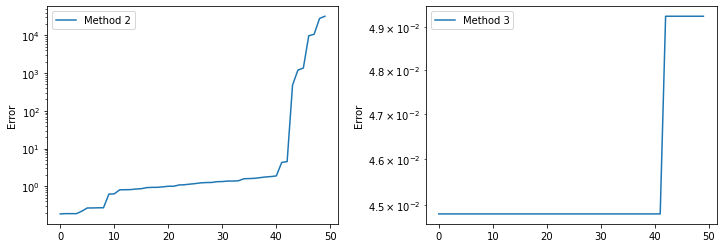

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(1, 2, 1)
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.plot(info2[:, 1], label='Method 2')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.plot(info3[:, 1], label='Method 3')
ax.legend()

plt.show()

These two error profiles look very different.
Because the methods use a different error function, the absolute magnitudes don't tell us much.
But it also appears that the errors are distributed differently, with method 2 showing a lot of variation, and method 3 showing veru similar scores for 40 out of 50 repeats.

We can quantify this notion by defining some (slightly arbitrary!) cut-off point of similarity, and counting how many are in each group:

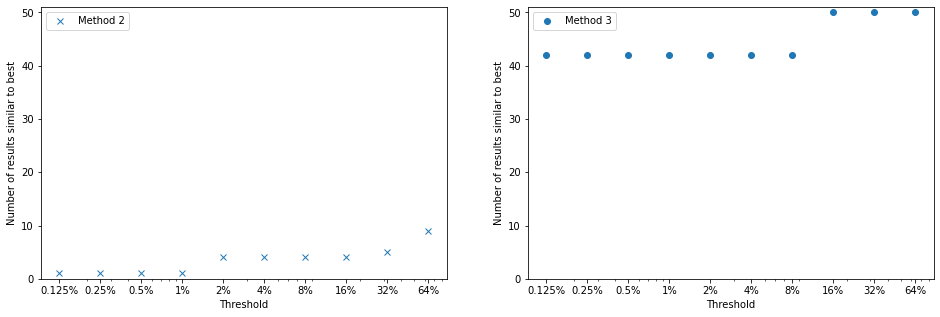

In [4]:
# Get errors
e2 = info2[:, 1]
e3 = info3[:, 1]

# Get errors relative to best (in percent)
r2 = 100 * (e2 - e2[0]) / e2[0]
r3 = 100 * (e3 - e3[0]) / e3[0]

# Loop over thresholds, defined as percentages
thresholds = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
best2 = []
best3 = []
for threshold in thresholds:
    # Count how many points are withing `threshold` % of best
    best2.append(len(r2[r2 < threshold]))
    best3.append(len(r3[r3 < threshold]))

# Plot
fig = plt.figure(figsize=[16, 5])

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of results similar to best')
ax.set_xscale('log')
ax.set_xticks(thresholds)
ax.set_xticklabels([str(i) + '%' for i in thresholds])
ax.set_ylim(0, 1 + len(e2))
ax.plot(thresholds, best2, 'x', label='Method 2')
ax.legend(loc='upper left')

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Threshold')
ax.set_ylabel('Number of results similar to best')
ax.set_xscale('log')
ax.set_xticks(thresholds)
ax.set_xticklabels([str(i) + '%' for i in thresholds])
ax.set_ylim(0, 1 + len(e3))
ax.plot(thresholds, best3, 'o', label='Method 3')
ax.legend(loc='upper left')

plt.show()   

This confirms what we saw before: For method 2 only a few points are close to the best point, and that number gets lower as we reduce the threshold. For method 3 the results still look like a split between two possible outcomes.

Picking 1% as our cut-off, we find:

In [5]:
# Count points near the best point
ebest2 = len(r2[r2 < 1])
ebest3 = len(r3[r3 < 1])
print('Number of points with error relative to best <1%:', ebest2)
print('Number of points with error relative to best <1%:', ebest3)

Number of points with error relative to best <1%: 1
Number of points with error relative to best <1%: 42


Or we can be a little bit less stringent and use 2%:

In [6]:
# Count points near the best point
ebest2 = len(r2[r2 < 2])
ebest3 = len(r3[r3 < 2])
print('Number of points with error relative to best <1%:', ebest2)
print('Number of points with error relative to best <1%:', ebest3)

Number of points with error relative to best <1%: 4
Number of points with error relative to best <1%: 42


What does this tell us about the quality of the results?

Using the 1% cut-off, we found a single clear winner for method 2: one point out of 50 got a much better score than the rest.
This could indicate that we have found the best point - but only once because it was very hard.
But it's also possible, and maybe more likely, that we haven't found the best solution yet and need more than 50 repeats!

For method 3 it looks like we might be OK, with 42 fits returning a very similar error.
However, without looking at the returned parameter values we can't tell if it was the same point every time.
In particular, if the problem is _unidentifiable_ there could still be lots of variation in the returned points, even though they have a similar score!

### Inspecting the returned parameters

We can plot the returned parameters on the "boundary plots" we created earlier:

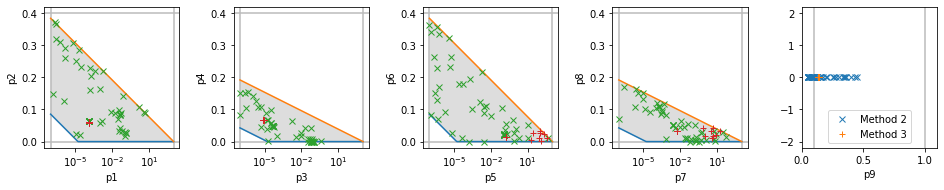

In [7]:
from library import multivariate_boundary_plot, boundary_plot_point

# Create a plot and show all results for method 2 and method 3
axes = multivariate_boundary_plot(a_log=True)
boundary_plot_point(axes, parameters2, 'x', label='Method 2')
boundary_plot_point(axes, parameters3, '+', label='Method 3')
axes[-1].legend()
plt.show()

This shows a bit of variation in the Method 3 results, and lots of variation from Method 2.

We can get a more informative plot by showing only those points near the best obtained solution:

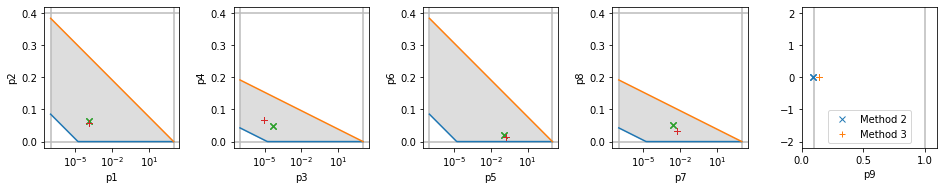

4 42


In [8]:
# Select only parameters with a score similar to the best score obtained, using 2% cut-off
pbest2 = parameters2[r2 < 2]
pbest3 = parameters3[r3 < 2]

# Create a plot and show selected results for method 2 and method 3
axes = multivariate_boundary_plot(a_log=True)
boundary_plot_point(axes, pbest2, 'x', label='Method 2')
boundary_plot_point(axes, pbest3, '+', label='Method 3')
axes[-1].legend()
plt.show()

print(len(pbest2), len(pbest3))

This is looking good for Method 3: all 42 points seem to overlap.
For Method 2 we can see a slight bluriness, but the points are much more concentrated than before.

We replot with a zoom-in to see it better

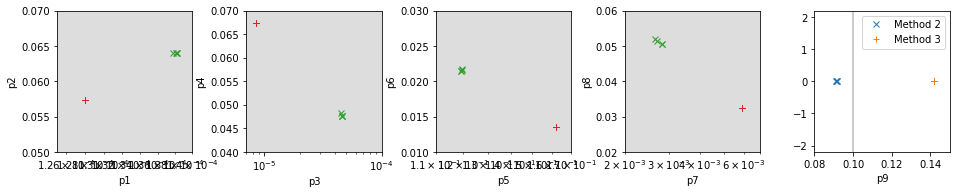

In [9]:
# Create plots and show selected results for methods 2 and 3
pbest2 = parameters2[r2 < 2]
pbest3 = parameters3[r3 < 2]
axes = multivariate_boundary_plot(a_log=True)
boundary_plot_point(axes, pbest2, 'x', label='Method 2')
boundary_plot_point(axes, pbest3, '+', label='Method 3')
axes[-1].legend()

axes[0].set_xlim(1.25e-4, 1.4e-4)
axes[0].set_ylim(0.05, 0.07)

axes[1].set_xlim(7e-6, 1e-4)
axes[1].set_ylim(0.04, 0.07)

axes[2].set_xlim(0.11, 0.17)
axes[2].set_ylim(0.01, 0.03)

axes[3].set_xlim(2e-3, 7e-3)
axes[3].set_ylim(0.02, 0.06)

axes[4].set_xlim(0.08, 0.15)

plt.show()

So it looks like the 4 best points found by Method 2 are quite similar, but still vary more than the 42 found with Method 3.

To quantify, we calculate the relative variation in each parameter compared to the best solution:
$$ \delta_{i,j} = \frac{|p_{i, j} - p_{0, j}|}{p_{0, j}} \cdot 100\% $$

where $p_0$ is the parameter set with the lowest error, and $p_{0,j}$ is the j-th parameter in that set.

Next, we define the maximum variation in a parameter set $i$ as:
$$ d_{i} = \max_j \frac{|p_{i, j} - p_{0, j}|}{p_{0, j}} \cdot 100\% $$

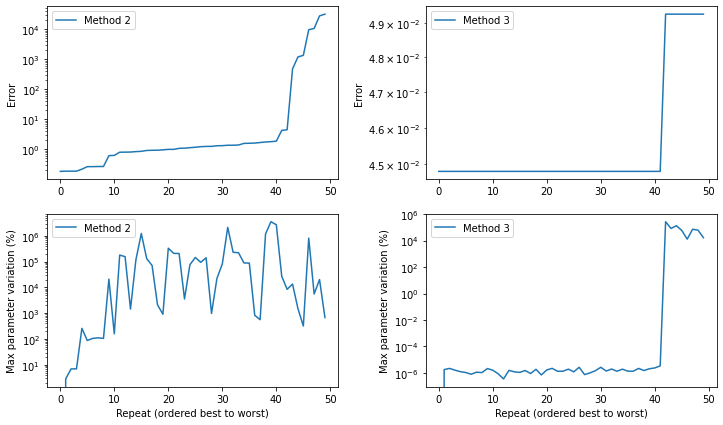

In [10]:
# Get maximum errors in parameter sets:
d2 = 100 * np.max(np.abs(parameters2 - parameters2[0]) / parameters2[0], axis=1)
d3 = 100 * np.max(np.abs(parameters3 - parameters3[0]) / parameters3[0], axis=1)

# Plot, along with scores
fig = plt.figure(figsize=(12, 7))
fig.subplots_adjust(wspace=0.3)

ax = fig.add_subplot(2, 2, 1)
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.plot(info2[:, 1], label='Method 2')
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.plot(info3[:, 1], label='Method 3')
ax.legend()

ax = fig.add_subplot(2, 2, 3)
ax.set_xlabel('Repeat (ordered best to worst)')
ax.set_ylabel('Max parameter variation (%)')
ax.set_yscale('log')
ax.plot(d2, label='Method 2')
ax.legend()

ax = fig.add_subplot(2, 2, 4)
ax.set_xlabel('Repeat (ordered best to worst)')
ax.set_ylabel('Max parameter variation (%)')
ax.set_yscale('log')
ax.plot(d3, label='Method 3')
ax.legend()

plt.show()

This gives a much clearer picture of the results!
For Method 2, we have a very small number of points with a fitting error similar to the best error obtained.
A few nearby points have a similar (but greater) error, but as soon as the error rises more the points start to jump all over the parameter space.

For method 3, we have a group of with identical low fitting errors, and these form a tight cluster in parameter space (relative difference < 1e-7). A few points have a larger error, and these are spread out over the parameter space.

As before, we can define cut-offs and count the number of results in each group:

In [11]:
# Get errors
e2 = info2[:, 1]
e3 = info3[:, 1]

# Get errors relative to best (in percent)
r2 = 100 * (e2 - e2[0]) / e2[0]
r3 = 100 * (e3 - e3[0]) / e3[0]

# Count number of points with error within 2% of best
ebest2 = len(r2[r2 < 2])
ebest3 = len(r3[r3 < 2])

print('Number of results with error within 2% of best obtained:')
print('Method 2: ' + str(ebest2))
print('Method 3: ' + str(ebest3))

# Count number of points with error within 2% of best, that also have less than 1% max variation in the parameters
pbest2 = parameters2[r2 < 2]
pbest3 = parameters3[r3 < 2]

dbest2 = 100 * np.max(np.abs(pbest2 - pbest2[0]) / pbest2[0], axis=1)
dbest3 = 100 * np.max(np.abs(pbest3 - pbest3[0]) / pbest3[0], axis=1)

print('Number of those results with less than 1% max parameter variation')
print('Method 2: ' + str(len(dbest2[dbest2 < 1])))
print('Method 3: ' + str(len(dbest3[dbest3 < 1])))

print('Number with less than 10% max parameter variation')
print('Method 2: ' + str(len(dbest2[dbest2 < 10])))
print('Method 3: ' + str(len(dbest3[dbest3 < 10])))

Number of results with error within 2% of best obtained:
Method 2: 4
Method 3: 42
Number of those results with less than 1% max parameter variation
Method 2: 1
Method 3: 42
Number with less than 10% max parameter variation
Method 2: 4
Method 3: 42


So Method 3 appears to be working well (or at least consistently): it finds the same point on 80% of all runs.

Method 2 on the other hand, is not very robust: if we're being picky we might say it finds only a single best point. If we're a bit more lenient we might say it finds a handful or "best" points, but the parameters within that set show not insignficant variation.

### Conclusion?

From the above analysis, we learn to treat results from Method 2 with suspicion.
But what have we learned about Method 3? We've seen that the method performs consistently, but the analysis cannot tell us if it has worked correctly.

We can, however, test if the model is useful...

## Testing the usefulness of your model: training and validation data

So far, we've:

1. Discussed how synthetic data studies can help us set up and debug our fitting software, although the real data may have sources of contamination we didn't consider in our noise model, and may not be perfectly fittable with our model.
2. Seen how a repeated-runs strategy can be used to detect problems, although it cannot show that a result is "right".

But the best test of a model (even a misspecified one!) is whether or not it makes good _predictions_.

In particular, while it is tempting to show off the "quality of fit" as proof of a good model, it is much more important that the model can produce good predictions of voltage protocols it was never trained on.
In [machine learning terms](https://en.wikipedia.org/wiki/Training%2C_validation%2C_and_test_sets), we should carefully design our experiments to generate both a _training set_ (used to train the model) and a _validation set_ (used to see if its predictions are any good).



In the paper ["Sinusoidal voltage protocols for rapid characterisation of ion channel kinetics"](https://doi.org/10.1113/JP276068) by Beattie et al., this was done by recording current with a sinusoidal protocol as training data, but with a separate AP-waveform protocol for validation.

As an example, we'll show a result obtained by fitting to the sinusoidal protocol, and then a prediction on the AP protocol.
For details of how these protocols are implemented in simulation please see the earlier tutorials.

In [63]:
import myokit

# Parameters giving best fit on the sinusoidal protocol, on the data set for "Cell 1"
# (Parameters as determined in the "Four ways" paper)
parameters = [
    1.97488396293571015e-04,
    5.93926012974279674e-02,
    7.16377910328610726e-05,
    4.93357304150380954e-02,
    1.04564468668640331e-01,
    1.38042995586312549e-02,
    3.81996945050016223e-03,
    3.60390982206262936e-02,
    1.34986219156051829e-01,
]

# Load the model
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')

# Apply parameters
for i, p in enumerate(parameters):
    model.get('ikr.p' + str(1 + i)).set_rhs(p)

# Load the step part of the sine wave protocol
protocol = myokit.load_protocol('resources/sine-wave-steps.mmt')

# Adapt for sine waves
c = model.get('membrane')
c.get('V').set_binding(None)
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')
model.get('membrane.V').set_rhs(
    'if(engine.time >= 3000.1 and engine.time < 6500.1,'
    + ' - 30'
    + ' + 54 * sin(0.007 * (engine.time - 2500.1))'
    + ' + 26 * sin(0.037 * (engine.time - 2500.1))'
    + ' + 10 * sin(0.190 * (engine.time - 2500.1))'
    + ', vp)')

# Run a simulation
sim = myokit.Simulation(model, protocol)
log = sim.run(tmax, log_times=times)

# Load the data that was fitted to
real = myokit.DataLog.load('resources/sine-wave-data/cell-1.zip')

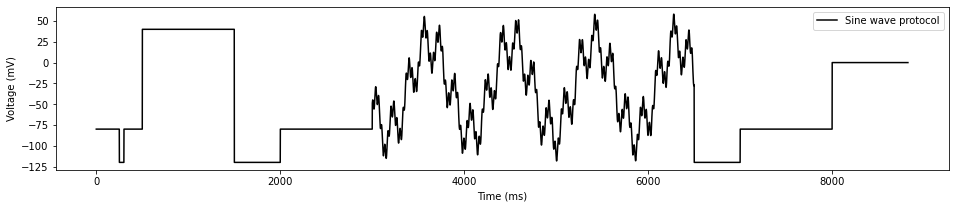

In [64]:
# Show the applied protocol
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.plot(log['engine.time'], log['membrane.V'], 'k', label='Sine wave protocol')
ax.legend()
plt.show()

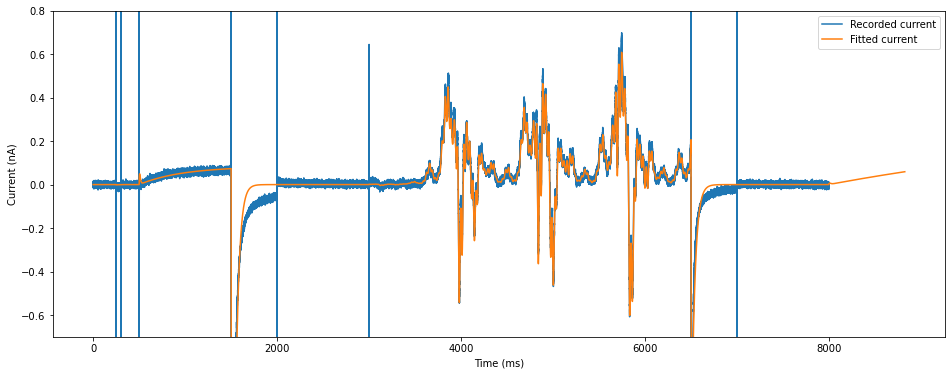

In [65]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (nA)')
ax.plot(real['time'], real['current'], label='Recorded current')
ax.plot(log['engine.time'], log['ikr.IKr'], label='Fitted current')
ax.legend()
ax.set_ylim(-0.7, 0.8)
plt.show()

Next, we show a _prediction_ on the AP protocol. This protocol was not used during fitting.

In [66]:
# Load the AP protocol
log = myokit.DataLog.load_csv('resources/ap.csv').npview()
log = log.npview()
times = log['time']
voltages = log['voltage']
del(log)

# Load the model and apply the parameters
model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
for i, p in enumerate(parameters):
    model.get('ikr.p' + str(1 + i)).set_rhs(p)

# Create a simulation with a fixed-form protocol
sim = myokit.Simulation(model)
sim.set_fixed_form_protocol(times, voltages)

# Run a simulation
tmax = log_1['time'][-1] + 1
log = sim.run(tmax, log_times=times)

# Load the experimentally recorded validation data
real = myokit.DataLog.load('resources/sine-wave-data/ap-cell-1.zip')

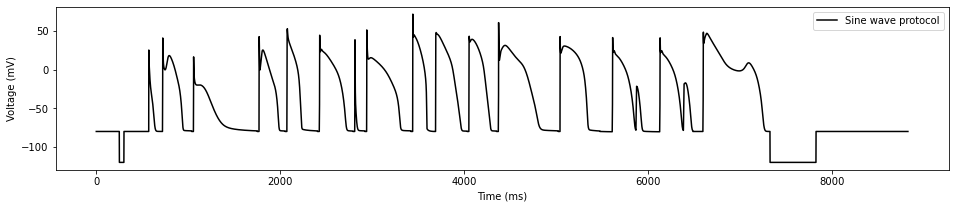

In [67]:
# Show the applied protocol
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.plot(log['engine.time'], log['membrane.V'], 'k', label='Sine wave protocol')
ax.legend()
plt.show()


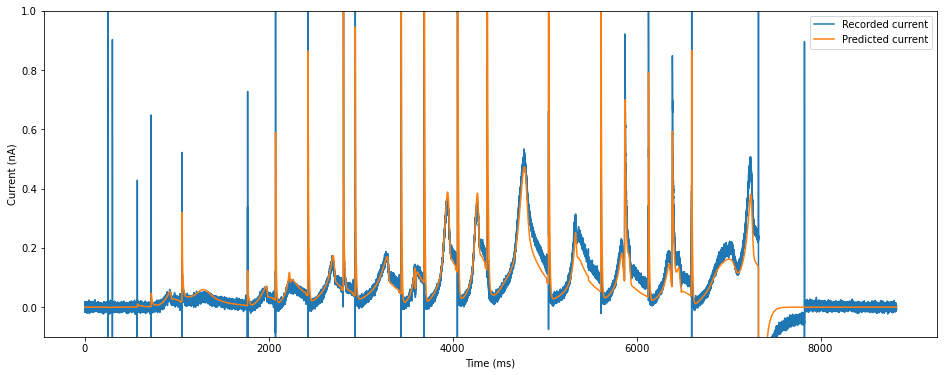

In [69]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (nA)')
ax.plot(real['time'], real['current'], label='Recorded current')
ax.plot(log['engine.time'], log['ikr.IKr'], label='Predicted current')
ax.legend()
ax.set_ylim(-0.1, 1)
plt.show()

Even though the fit wasn't perfect, we get very good predictions on the validation set, showing that this is a useful model!

### Three data sets?

Some machine learning studies go even further, and use three independent data sets:

1. A training set, to which models are fit.
2. A validation set, used to test the models performance. Based on these results, the method may be tweaked by the experimenter!
3. A test set, used to test the performance of the final model selected during validation.

For more on these ideas, see the wikipedia entry linked above.
For its application to ion current models, see ["Calibration of ionic and cellular cardiac electrophysiology models"](https://doi.org/10.1002/wsbm.1482).

## Summary

In this notebook we've:

- Discussed the usefulness and possible limitations of synthetic data studies
- Used repeated fits to test if fitting methods are robust
- Shown how an independent validation data set can be used to show a model's usefulness.
